In [125]:
import os
import math
import json
import csv
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime

In [42]:
Data_Root = '/home/haopeng/Data/Promotion/'

In [4]:
# pd.options.display.precision = 20

In [43]:
CIs = {'90': 1.645, '95': 1.96, '99': 2.576}

In [44]:
labels = ['Male', 'Female']

In [45]:
colors = sns.color_palette()[:len(labels)]

In [88]:
# load reg data with basic controls
utype = {'author_id': str, 'matched_tid': 'str', 'matched_tid_original': 'str', 'matched_tid_retweet': 'str'}
reg_data = pd.read_csv(Data_Root+"reg_data.csv", header=0, dtype=utype)

In [47]:
# before dropping missing values
reg_data.shape

(6363409, 58)

In [48]:
reg_data.isna().sum()

doi                                                   0
author_name                                           0
authorship_seq                                        0
authorship_pos                                        0
author_id                                             0
affiliation_ids                                 2043973
self_promotion_original                               0
gender                                                0
num_authors                                           0
author_rank                                           0
affiliation_name                                      0
affiliation_cate                                      0
affiliation_rank                                2043973
journal_title                                         0
journal_impact                                  2025383
top_journal                                           0
self_promotion                                        0
pub_year                                        

In [91]:
# num of obs in regression
inx = reg_data[reg_data.columns[~reg_data.columns.isin(['matched_tid', 'matched_tid_original', 'matched_tid_retweet'])]].dropna().index


In [92]:
len(inx)

3073001

In [93]:
reg_data = reg_data.loc[inx]
reg_data.index = range(len(reg_data))

In [94]:
del inx

### Add total mentions and self-promotion position

In [10]:
dois = set(reg_data.doi)

In [11]:
len(dois)

564748

In [12]:
doi_tids = {}
with open(Data_Root+'papers_2018.json', 'r') as ifile:
    for line in ifile:
        res = json.loads(line)
        doi = res['doi']
        if doi in dois:
            doi_tids[doi] = [tweet['tweet_id'] for tweet in res['data']['tweets']]

In [13]:
len(doi_tids)

564748

In [18]:
tids = set()
for doi in doi_tids:
    for tid in doi_tids[doi]:
        tids.add(tid)

In [19]:
len(tids)

7272113

In [19]:
tid_date_all = {}
tid_follow_cn_all = {}

with open(Data_Root+'tweets_v2.json', 'r') as ifile:
    for line in ifile:
        line = json.loads(line)
        tid, tdate = line['id_str'], line['created_at']
        if tid in tids:
            tid_date_all[tid] = datetime.strptime(tdate, '%a %b %d %H:%M:%S +0000 %Y')#.strftime("%Y-%m-%d")
            tid_follow_cn_all[tid] = line['user']['followers_count']

# this file is collected earlier
with open(Data_Root+'tweets_v2_non_full_text.json', 'r') as ifile:
    for line in ifile:
        line = json.loads(line)
        tid, tdate = line['id_str'], line['created_at']
        if tid in tids:
            # tid_name_all[tid] = line['user']['name']
            tid_date_all[tid] = datetime.strptime(tdate, '%a %b %d %H:%M:%S +0000 %Y')#.strftime("%Y-%m-%d")
            tid_follow_cn_all[tid] = line['user']['followers_count']

In [20]:
len(tid_date_all)

6742298

In [21]:
len(tid_follow_cn_all)

6742298

In [39]:
tid_date_all['1000450019865120768']

datetime.datetime(2018, 5, 26, 18, 54, 6)

In [42]:
tid_date_all['1000890079244619776']

datetime.datetime(2018, 5, 28, 0, 2, 45)

In [33]:
tid_date_all['1002340016134246400']

datetime.datetime(2018, 6, 1, 0, 4, 17)

In [43]:
sorted(['1002340016134246400', '1000450019865120768', '1000890079244619776'], key=lambda tid: tid_date_all[tid])

['1000450019865120768', '1000890079244619776', '1002340016134246400']

Count num of tweets for the final set of papers

In [14]:
# focus on Male and Female
len(reg_data.loc[reg_data['gender'].isin(['Female', 'Male'])])

2380098

In [16]:
cn = 0
for doi in set(reg_data.loc[reg_data['gender'].isin(['Female', 'Male'])]['doi']):
    cn += len(doi_tids[doi])

In [17]:
cn

7228416

In [42]:
def check_early_self_promo(row):
    doi, p_0, mat_tid = row['doi'], row['self_promotion'], row['matched_tid']
    valid_tids = [tid for tid in doi_tids[doi] if tid in tid_date_all]
    total = len(valid_tids)
    if p_0:
        sort_tids = sorted(valid_tids, key=lambda tid: tid_date_all[tid])
        # valid_users = [tid_name_all[tid] for tid in sort_tids]
        # ix = valid_users.index(t_user)
        ix = sort_tids.index(mat_tid) + 1
        return (total, ix, ix/total)
    else:
        return (total, -1, -1)

In [43]:
reg_data['Tem'] = reg_data.apply(lambda row: check_early_self_promo(row), axis = 1)
reg_data[['total_num_tweets', 'self_promo_position', 'self_promo_position_frac']] = pd.DataFrame(reg_data.Tem.values.tolist(), index = reg_data.index)
reg_data = reg_data.drop(columns=['Tem'])


In [65]:
np.sum(reg_data['self_promotion'] == True)

191637

In [73]:
np.sum(reg_data['self_promotion'] == False)

2881364

In [44]:
np.sum(reg_data['self_promo_position'] == 1)

55185

In [107]:
np.sum(reg_data['self_promo_position'] == 1) / 191637

0.28796631130731537

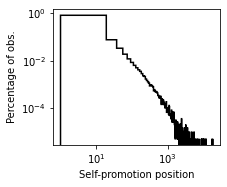

In [104]:
fig, ax = plt.subplots(figsize = (3, 2.5))

lli = np.array(reg_data.loc[reg_data['self_promotion'] == True]['self_promo_position'].tolist())
n = len(lli)
ax.hist(lli, bins = 1000, color='k', alpha=1, linewidth=1.5, histtype='step', weights=np.ones(n)/n)
ax.set_ylabel('Percentage of obs.')
ax.set_xlabel('Self-promotion position')
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim(right=1e4)
# legend = ax.legend(loc=[0.55, 0.7], numpoints=2, labelspacing = 0.15, shadow=False, frameon = False)
plt.show()
fig.savefig('pos_hist.pdf', bbox_inches='tight', pad_inches=0.02)

In [103]:
np.sum(lli <= 10)/len(lli)

0.7080052390717868

### Add num. of followers control

In [67]:
def get_tid_follower_cn(row):
    doi, p_0, mat_tid = row['doi'], row['self_promotion'], row['matched_tid']
    if p_0:
        return tid_follow_cn_all[mat_tid]
    else:
        return -1

In [68]:
reg_data['matched_tid_follower_cn'] = reg_data.apply(get_tid_follower_cn, axis=1)

In [69]:
reg_data.head()

,doi,author_name,authorship_seq,authorship_pos,author_id,affiliation_ids,self_promotion_original,gender,num_authors,author_rank,...,Physical_Sciences,author_num_papers_in_data,author_self_promotion_rate,matched_tid_original,matched_tid_retweet,matched_tid,total_num_tweets,self_promo_position,self_promo_position_frac,matched_tid_follower_cn
0,10.1109/tmag.2017.2750019,Daniel S. Gazzana,1,first_position,2040190777,130442723,False,Male,6,16859,...,1,1,0.0,NaN,NaN,NaN,0,-1,-1.0,-1
1,10.1109/tmag.2017.2750019,Arturo S. Bretas,4,middle_position,2115308334,130442723,False,Male,6,15192,...,1,2,0.0,NaN,NaN,NaN,0,-1,-1.0,-1
2,10.1109/tmag.2017.2750019,Roberto C. Leborgne,3,middle_position,2145772920,130442723,False,Male,6,16228,...,1,2,0.5,NaN,NaN,NaN,0,-1,-1.0,-1
3,10.1109/tmag.2017.2750019,Christos Christopoulos,6,last_position,2162061708,142263535,False,Male,6,14318,...,1,1,0.0,NaN,NaN,NaN,0,-1,-1.0,-1
4,10.1109/tmag.2017.2750019,Dave W. P. Thomas,5,middle_position,2186954650,142263535,False,Male,6,16333,...,1,2,0.0,NaN,NaN,NaN,0,-1,-1.0,-1


### Outdated below >>>

The fig below is misleading because the def of timing (fractional) is correlated with total # mentions.

In [46]:
len(reg_data.loc[reg_data.total_num_tweets >= 20])

402661

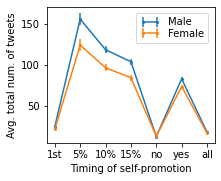

In [87]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3, 2.5))
xs = [0, 1, 2, 3, 4, 5, 6]
ys = [[], []]
confs = [[], []]

for ix, gen, col in zip([0, 1], labels, colors):
    li_0 = reg_data.loc[(reg_data['gender'] == gen) & (reg_data['self_promo_position'] == 1)]['total_num_tweets'].tolist()
    cut = 0.05
    li_1 = reg_data.loc[(reg_data['gender'] == gen) & (reg_data['self_promo_position_frac'].apply(lambda x: x > 0 and x < cut))]['total_num_tweets'].tolist()
    cut = 0.1
    li_2 = reg_data.loc[(reg_data['gender'] == gen) & (reg_data['self_promo_position_frac'].apply(lambda x: x > 0 and x < cut))]['total_num_tweets'].tolist()
    cut = 0.15
    li_3 = reg_data.loc[(reg_data['gender'] == gen) & (reg_data['self_promo_position_frac'].apply(lambda x: x > 0 and x < cut))]['total_num_tweets'].tolist()
    li_no = reg_data.loc[(reg_data['gender'] == gen) & (reg_data['self_promotion'] == False)]['total_num_tweets'].tolist()
    li_yes = reg_data.loc[(reg_data['gender'] == gen) & (reg_data['self_promotion'] == True)]['total_num_tweets'].tolist()
    li_all = reg_data.loc[reg_data['gender'] == gen]['total_num_tweets'].tolist()
    for li_ in [li_0, li_1, li_2, li_3, li_no, li_yes, li_all]:
        ys[ix].append(np.mean(li_))
        confs[ix].append(CIs['95'] * np.std(li_) / np.sqrt(len(li_)))
    ax.errorbar(xs, ys[ix], yerr=confs[ix], fmt='-o', markersize=2, linewidth=1.5, label=gen, color=col)
    
legend = ax.legend(bbox_to_anchor=(0.5, 0.7), loc='lower left', numpoints=2, labelspacing = 0.15, shadow=False, frameon = True, markerscale = 1)

# ax.set_yticks([0.01, 0.03, 0.05, 0.07, 0.09])
ax.set_xticks(xs)
xticklabs = ['1st', '5%', '10%', '15%', 'no', 'yes', 'all']
ax.set_xticklabels(xticklabs)
# for tick in ax.get_xticklabels():
#     tick.set_ha('right')
#     tick.set_fontsize(8)
#     tick.set_rotation(30)
ax.set_xlabel('Timing of self-promotion')
ax.set_ylabel('Avg. total num. of tweets')

# plt.tight_layout()
plt.show()
fig.savefig('./avg_total_mentions.pdf', bbox_inches='tight', pad_inches=0.01)


In [88]:
ys[0]

[24.786151295099778,
 155.73289610970338,
 118.43404937981767,
 103.77764595519258,
 12.683786965688245,
 82.91078635813265,
 18.179995854131228]

In [89]:
ys[1]

[21.599015317286653,
 124.08859416445624,
 96.44756290691537,
 84.27445103676065,
 12.972780392249357,
 73.56687411289442,
 16.84243468721565]

In [90]:
for ix, ym, yf in zip(xticklabs, ys[0], ys[1]):
    print(ix, '\t', (ym-yf)/yf)

1st 	 0.14755931837607048
5% 	 0.2550137839688032
10% 	 0.22796311083694423
15% 	 0.23142476371545398
no 	 -0.02227690732618674
yes 	 0.12701249520129435
all 	 0.07941614094136051


In [47]:
len(li_0)

14624

In [48]:
len(li_1)

5655

In [51]:
len(li_2)

11366

In [52]:
len(li_3)

16349

In [49]:
len(li_no)

805559

In [91]:
len(li_yes)

54954

In [77]:
len(reg_data.loc[(reg_data['self_promotion'] == False) & (reg_data['gender'] == 'Female')])

805559

In [78]:
len(reg_data.loc[(reg_data['self_promotion'] == False) & (reg_data['gender'] == 'Male')])

1400657

In [50]:
len(li_all)

860513

### <<< Outdated above

### Different definition of self-promotion

Define self-promotion timing as the actual time difference between promotion time and publication date

In [115]:
doi_pub_date = {}

cn_lines = 0
with open('/home/haopeng/Data/Retraction/merged.txt', 'r') as ofile:
    for row in ofile:
        cn_lines += 1
        if cn_lines % 1000000 == 0:
            print('processed %d lines...'%cn_lines)
        if '}{"altmetric_id"' in row:
            row = row.replace('}{"altmetric_id"', '}\n{"altmetric_id"')
        # this way works for both good and bad lines.
        records = row.split('\n')
        for record in records:
            if record != '':
                paper = json.loads(record)
                citation = paper['citation']
                pubdate = ''
                if 'pubdate' in citation:
                    pubdate = citation['pubdate']
                elif 'epubdate' in citation:
                    pubdate = citation['epubdate']
                doi = ''
                if 'doi' in citation:
                    doi = citation['doi']
                if doi in dois:
                    doi_pub_date[doi] = pubdate

processed 1000000 lines...
processed 2000000 lines...
processed 3000000 lines...
processed 4000000 lines...
processed 5000000 lines...
processed 6000000 lines...
processed 7000000 lines...
processed 8000000 lines...
processed 9000000 lines...
processed 10000000 lines...
processed 11000000 lines...
processed 12000000 lines...
processed 13000000 lines...
processed 14000000 lines...
processed 15000000 lines...
processed 16000000 lines...
processed 17000000 lines...
processed 18000000 lines...
processed 19000000 lines...
processed 20000000 lines...
processed 21000000 lines...
processed 22000000 lines...
processed 23000000 lines...
processed 24000000 lines...
processed 25000000 lines...


In [116]:
def cal_self_promo_time(row):
    doi, p_0, mat_tid = row['doi'], row['self_promotion'], row['matched_tid']
    if p_0:
        promo_time = tid_date_all[mat_tid]
        pub_time = doi_pub_date[doi]
        pub_time = datetime.strptime(pub_time, '%Y-%m-%dT%H:%M:%S+00:00')
        delta = (promo_time - pub_time).total_seconds()
        if delta <= 0:
            return 0
        else:
            return delta
    else:
        return -1

In [117]:
reg_data['self_promo_time'] = reg_data.apply(lambda row: cal_self_promo_time(row), axis = 1)

In [119]:
reg_data.loc[reg_data['self_promo_time'] != -1]

,doi,author_name,authorship_seq,authorship_pos,author_id,affiliation_ids,self_promotion_original,gender,num_authors,author_rank,...,author_num_papers_in_data,author_self_promotion_rate,matched_tid_original,matched_tid_retweet,matched_tid,total_num_tweets,self_promo_position,self_promo_position_frac,matched_tid_follower_cn,self_promo_time
7,10.1111/jofo.12266,David Canal,3,middle_position,2168392039,134820265|151201029,False,Male,4,17023,...,5,0.400000,NaN,1074690500261830656,1074690500261830656,13,13,1.000000,588,1438756.0
12,10.1111/ejn.13879,Abigail M. Polter,1,first_position,1994828131,27804330,True,Female,4,18498,...,1,1.000000,973983994038628352,NaN,973983994038628352,10,1,0.100000,1362,0.0
31,10.1108/jhom-10-2017-0266,Yvonne Sawbridge,2,middle_position,108076037,79619799,True,Female,6,17955,...,1,1.000000,979347729687220224,NaN,979347729687220224,20,1,0.050000,1691,0.0
47,10.1080/17461391.2018.1439535,Matthew Driller,4,last_position,2915820210,52179390,True,Male,4,17976,...,6,1.000000,968344007108636673,990685286920208384,968344007108636673,49,1,0.020408,2663,0.0
48,10.1080/17461391.2018.1439535,Steve Bird,2,middle_position,2916899503,52179390,False,Male,4,17805,...,3,0.333333,NaN,969291756935307265,969291756935307265,49,25,0.510204,310,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3072942,10.1002/ejoc.201800424,Toshiaki Shimasaki,8,middle_position,2073876528,8488066,True,Male,9,17281,...,2,0.500000,1017578726748377089,NaN,1017578726748377089,3,2,0.666667,298,4648.0
3072951,10.1016/j.neuroimage.2017.05.050,Vince Daniel Calhoun,2,middle_position,47842845,169521973|1334567473,True,Male,7,12627,...,75,0.546667,987014794006806528,NaN,987014794006806528,39,39,1.000000,4458,0.0
3072960,10.1016/j.jebo.2018.02.018,Cecilia Hermansson,1,solo_author,2081555386,86987016,True,Female,1,18241,...,1,1.000000,970973316512088064,NaN,970973316512088064,5,1,0.200000,2796,0.0
3072986,10.1016/j.amjsurg.2018.07.064,Arghavan Salles,4,last_position,2115201536,97018004,True,Female,4,17007,...,4,0.750000,1147915473536737280,1045789314880233472,1147915473536737280,18,18,1.000000,43622,24167350.0


In [123]:
np.median(reg_data[reg_data.self_promotion == True]['self_promo_time'])

0.0

In [124]:
np.mean(reg_data[reg_data.self_promotion == True]['self_promo_time'])

1959353.9666139628

In [121]:
np.mean(reg_data.total_num_tweets)

15.885128250853157

Consider promotion within one day after publication as self-promotion

In [125]:
day_sec = 3600*24
thsh = 1

def promo_fun(delta):
    if delta == -1:
        return False
    else:
        if delta <= day_sec * thsh:
            return True
        else:
            return False

In [126]:
reg_data['self_promotion_def'] = reg_data['self_promo_time'].apply(promo_fun)

In [132]:
reg_data.loc[reg_data['self_promotion_def'] == True, ['self_promo_time', 'self_promotion_def']]

,self_promo_time,self_promotion_def
12,0.0,True
31,0.0,True
47,0.0,True
48,0.0,True
197,0.0,True
...,...,...
3072912,0.0,True
3072942,4648.0,True
3072951,0.0,True
3072960,0.0,True


### Add audiences (DV)

In [24]:
len(dois)

564748

In [28]:
doi_tw_aud = {}
cn_lines = 0

with open('/home/haopeng/Data/Retraction/merged.txt', 'r') as ofile:
    for row in ofile:
        cn_lines += 1
        if cn_lines % 1000000 == 0:
            print('processed %d lines...'%cn_lines)
        if '}{"altmetric_id"' in row:
            row = row.replace('}{"altmetric_id"', '}\n{"altmetric_id"')
        # this way works for both good and bad lines.
        records = row.split('\n')
        for record in records:
            if record != '':
                paper = json.loads(record)
                citation = paper['citation']
                doi = ''
                if 'doi' in citation:
                    doi = citation['doi']
                if doi in dois and 'poster_types' in paper['demographics']:
                    doi_tw_aud[doi] = paper['demographics']['poster_types']

processed 1000000 lines...
processed 2000000 lines...
processed 3000000 lines...
processed 4000000 lines...
processed 5000000 lines...
processed 6000000 lines...
processed 7000000 lines...
processed 8000000 lines...
processed 9000000 lines...
processed 10000000 lines...
processed 11000000 lines...
processed 12000000 lines...
processed 13000000 lines...
processed 14000000 lines...
processed 15000000 lines...
processed 16000000 lines...
processed 17000000 lines...
processed 18000000 lines...
processed 19000000 lines...
processed 20000000 lines...
processed 21000000 lines...
processed 22000000 lines...
processed 23000000 lines...
processed 24000000 lines...
processed 25000000 lines...


In [29]:
len(doi_tw_aud)

472831

In [32]:
doi_tw_aud['10.1001/jama.2018.17121']

{'member_of_the_public': 47,
 'researcher': 11,
 'practitioner': 21,
 'science_communicator': 4}

In [33]:
def get_num_audiences(doi, kind = 'member_of_the_public'):
    if doi in doi_tw_aud and kind in doi_tw_aud[doi]:
        return doi_tw_aud[doi][kind]
    else:
        return 0

In [34]:
reg_data['member_of_the_public'] = reg_data['doi'].apply(lambda doi: get_num_audiences(doi, 'member_of_the_public'))
reg_data['researcher'] = reg_data['doi'].apply(lambda doi: get_num_audiences(doi, 'researcher'))
reg_data['practitioner'] = reg_data['doi'].apply(lambda doi: get_num_audiences(doi, 'practitioner'))
reg_data['science_communicator'] = reg_data['doi'].apply(lambda doi: get_num_audiences(doi, 'science_communicator'))

In [75]:
reg_data['num_non_scientists'] = reg_data[['member_of_the_public', 'practitioner', 'science_communicator']].sum(axis=1)


In [38]:
np.sum(reg_data['researcher'])

10833556

In [76]:
np.sum(reg_data['num_non_scientists'])

34055900

### Add author ethnicity (focus on male and female to reduce the number of authors queried)

In [77]:
# focus on Male and Female
len(reg_data.loc[reg_data['gender'].isin(['Female', 'Male'])])

2380098

In [13]:
eth_url = 'http://abel.lis.illinois.edu/cgi-bin/ethnea/search.py?format=json'

In [ ]:
name_eth_gen = {}

# focus on Male and Female
# 2.38M rows
for ix, name in enumerate(set(reg_data.loc[reg_data['gender'].isin(['Female', 'Male'])]['author_name'])):
    if name not in name_eth_gen:
        payload = parse_author_name(name)
        if payload != 'invalid':
            if ix%1000 == 0:
                time.sleep(5)
            response = requests.get(eth_url, params=payload)
            try:
                j = eval(response.text)
                genni = j['Genni']
                ethnea = j['Ethnea']
                name_eth_gen[name] = {'Ethnea': ethnea, 'Genni': genni}
            except:
                continue
            if ix%1000000 == 0:
                print("%d/%d" %(ix, len(author_names)))

In [18]:
with open(Data_Root+'name_eth_gen.json', 'w') as ofile:
    for name, info in name_eth_gen.items():
        row = {'name': name, 'info': info}
        ofile.write(json.dumps(row) + '\n')

In [78]:
name_eth_gen = {}

with open(Data_Root+'name_eth_gen.json', 'r') as ofile:
    for row in ofile:
        row = json.loads(row)
        name, info = row['name'], row['info']
        name_eth_gen[name] = info

In [79]:
len(name_eth_gen)

1309714

Add inferred ethnicity (based on Ethnea)

In [80]:
eth_cat_map = {
 'ISRAELI': 'MiddleEastern',
 'ARAB': 'MiddleEastern',
 'TURKISH': 'MiddleEastern',
 'ENGLISH': 'English',
 'HISPANIC': 'SouthernEuropean',
 'ITALIAN': 'SouthernEuropean',    
 'GREEK': 'SouthernEuropean',
 'GERMAN': 'WesternNorthernEuropean',
 'NORDIC': 'WesternNorthernEuropean',
 'DUTCH': 'WesternNorthernEuropean',
 'FRENCH': 'WesternNorthernEuropean',
 'BALTIC': 'WesternNorthernEuropean',
 'HUNGARIAN': 'EasternEuropean',
 'ROMANIAN': 'EasternEuropean',
 'SLAV': 'EasternEuropean',
 'CHINESE': 'Chinese',
 'INDIAN': 'Indian',
 'AFRICAN': 'African',
 'KOREAN': 'EastAsian',
 'JAPANESE': 'EastAsian',
 'THAI': 'EastAsian',
 'VIETNAMESE': 'EastAsian',
 'INDONESIAN': 'EastAsian',
 'MONGOLIAN': 'EastAsian',
 'CARIBBEAN': 'CARIBBEAN',
 'POLYNESIAN': 'POLYNESIAN',
 'org': 'org',
 'unknown': 'unknown'}

In [82]:
def parse_author_name(name):
    words = name.split()
    # must has first and last name to query the API
    if len(words) <= 1:
        payload = 'invalid'
    else:
        payload = {'Fname': words[0], 'Lname': words[-1]}
        # C. Kirabo Jackson
        if len(words) >= 3:
            # C or C.
            if len(words[0]) == 1 or (len(words[0]) == 2 and words[0][1] == '.'):
                # not C. J. Jackson; but C. Del Jackson
                if len(words[1]) > 2 or (len(words[1]) == 2 and words[1][1] != '.'):
                    given = words[1]
                    family = words[-1]
                    payload = {'Fname': given, 'Lname': family}
    return payload

name_filter = set(['consortium', 'collaboration', 'collaboration*', 'editor', 'bank'])

def get_author_eth_gen(name):
    # invalid: single-word-name
    feats = ['unknown', 'unknown']
    name_tupe = parse_author_name(name)
    if type(name_tupe) == dict:
        family = name_tupe['Lname']
        # The XXX Collaboration would go to API as well since the Lname is Collaboration.
        if family.lower() in name_filter:
            feats = ['org', 'org']
        else:
            if name in name_eth_gen:
                # ethnicity
                major = name_eth_gen[name]['Ethnea'].split('-')[0]
                if major != "ERROR" and major != 'UNKNOWN' and major != 'TOOSHORT':
                    feats[0] = major
                # gender
                gender = name_eth_gen[name]['Genni']
                if gender != '-':
                    feats[1] = gender
    return feats

In [83]:
reg_data['author_eth_gen'] = reg_data['author_name'].apply(lambda name: get_author_eth_gen(name))
reg_data[['author_eth_ethnea', 'author_gender_ethnea']] = pd.DataFrame(reg_data['author_eth_gen'].values.tolist(), index = reg_data.index)
reg_data = reg_data.drop(columns = ['author_eth_gen'])
reg_data['author_eth_ethnea_broad'] = reg_data['author_eth_ethnea'].map(eth_cat_map)


In [84]:
len(reg_data)

3073001

In [102]:
reg_data.head(3)

,doi,author_name,authorship_seq,authorship_pos,author_id,affiliation_ids,self_promotion_original,gender,num_authors,author_rank,...,self_promotion_def,member_of_the_public,researcher,practitioner,science_communicator,author_citation,num_non_scientists,author_eth_ethnea,author_gender_ethnea,author_eth_ethnea_broad
0,10.1109/tmag.2017.2750019,Daniel S. Gazzana,1,first_position,2040190777,130442723,False,Male,6,16859,...,False,0,0,0,0,101,0,FRENCH,M,WesternNorthernEuropean
1,10.1109/tmag.2017.2750019,Arturo S. Bretas,4,middle_position,2115308334,130442723,False,Male,6,15192,...,False,0,0,0,0,855,0,HISPANIC,M,SouthernEuropean
2,10.1109/tmag.2017.2750019,Roberto C. Leborgne,3,middle_position,2145772920,130442723,False,Male,6,16228,...,False,0,0,0,0,256,0,ITALIAN,M,SouthernEuropean


In [103]:
reg_data.to_csv(Data_Root+"reg_data_drop_missing.csv", index=False, header=True, encoding='utf-8')

In [98]:
utype = {'author_id': str, 'matched_tid': 'str', 'matched_tid_original': 'str', 'matched_tid_retweet': 'str'}
reg_data = pd.read_csv(Data_Root+"reg_data_drop_missing.csv", header=0, dtype=utype)

Explore

In [122]:
def yield_one_line(filename, delimiter = '\t', quote = csv.QUOTE_NONE):
    '''a generator which produce one line of a given file'''
    with open(filename, 'r') as file:
        print('processing %s...' %(filename))
        reader = csv.reader(file, delimiter=delimiter, quoting=quote)
        for row in reader:
            yield row

In [123]:
affi_name = {}
for line in yield_one_line(Data_Root+'Affiliations.txt'):
    affi_id, rank, dname, lat, lon = line[0], line[1], line[3], line[9], line[10]
    affi_name[affi_id] = dname

processing /home/haopeng/Data/Promotion/Affiliations.txt...


In [115]:
reg_data.loc[reg_data.affiliation_rank_cate == 9]#['affiliation_ids']

,doi,author_name,authorship_seq,authorship_pos,author_id,affiliation_ids,self_promotion_original,gender,num_authors,author_rank,...,self_promotion_def,member_of_the_public,researcher,practitioner,science_communicator,author_citation,num_non_scientists,author_eth_ethnea,author_gender_ethnea,author_eth_ethnea_broad
34,10.1108/jhom-10-2017-0266,Sarah Lehmann,5,middle_position,2794836768,2800115762,False,Female,6,20976,...,False,12,3,4,0,0,16,GERMAN,F,WesternNorthernEuropean
37,10.1194/jlr.m082495,Dana K. Merriman,2,middle_position,2036828638,64185308,False,Female,11,17651,...,False,6,2,0,1,123,7,ENGLISH,unknown,English
53,10.1016/j.chb.2018.05.010,Paul van Schaik,2,last_position,2141674712,874055015,False,Male,2,15208,...,False,1,0,0,1,1875,2,DUTCH,M,WesternNorthernEuropean
76,10.1016/j.mattod.2017.11.005,Xianlong Cao,4,middle_position,2772128816,168337820,False,Unknown,11,19933,...,False,0,0,0,0,0,0,unknown,unknown,unknown
84,10.1016/j.rinp.2018.08.039,G. Ramos-Ortiz,2,middle_position,669765303,2799391333,False,Male,6,15628,...,False,1,0,0,0,1035,1,HISPANIC,unknown,SouthernEuropean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3072956,10.1016/j.neuroimage.2017.05.050,Robyn Miller,5,middle_position,2945190397,1334567473,False,Female,7,17676,...,False,23,11,1,0,252,24,ENGLISH,F,English
3072961,10.1039/c8md00114f,Karsten Juhl,6,last_position,1776708227,133593841,False,Male,6,16473,...,False,3,3,0,0,134,3,NORDIC,M,WesternNorthernEuropean
3072962,10.1039/c8md00114f,Erling B. Jorgensen,4,middle_position,2105238312,133593841,False,Male,6,18089,...,False,3,3,0,0,100,3,NORDIC,M,WesternNorthernEuropean
3072964,10.1039/c8md00114f,Claus T. Christoffersen,5,middle_position,2166360461,133593841,False,Male,6,17018,...,False,3,3,0,0,250,3,NORDIC,M,WesternNorthernEuropean


In [128]:
for affi_id in random.sample(set(reg_data.loc[reg_data.affiliation_rank_cate == 9]['affiliation_ids']), 100):
    if '|' not in affi_id:
        print(affi_name[affi_id])

Minnesota Department of Natural Resources
The Seoul Institute
Jumonji University
Western Connecticut State University
David Grant USAF Medical Center
Rivers State University of Science and Technology
White & Case
Eurotransplant
Middle East Institute
South Shields
Edward Hines, Jr. VA Hospital
HIV/AIDS Bureau
International Seabed Authority
University of Mary Hardin–Baylor
Sabah Wildlife Department
P.G. College
Unimontes
Yukon Kuskokwim Health Corporation
Duke Energy
Central Rice Research Institute
Romanian Space Agency
University System of Georgia
Wittenberg University
Universiti Brunei Darussalam
Catholic University of Pusan
St Woolos Hospital
WellStar Health System
Carestream Health
Karpagam University
Defence Research and Development Organisation
University of the Thai Chamber of Commerce
South Korean Ministry for Health, Welfare and Family Affairs
Sonora Institute of Technology
AOAC International
University of Talca
University of the Arts Helsinki
Lynchburg College
Federal Institute

### (outdated) Author-level analysis (the same setup as in Agnes's PNAS paper)

In [133]:
len(reg_data)

3073001

In [142]:
tem = []
for aid, gp in reg_data.groupby('author_id'):
    gender = gp['gender'].values[0]
    author_rank = gp['author_rank'].values[0]
    pub_cn_cate = gp['author_pub_count_cate'].values[0]
    fcn = gp['matched_tid_follower_cn'].values[0]
    jif_sum = sum(gp['journal_impact'])
    tcn = sum(gp['total_num_tweets'])
    tem.append([aid, gender, author_rank, pub_cn_cate, fcn, jif_sum, tcn])

In [143]:
tem = pd.DataFrame(tem, columns=['author_id', 'gender', 'author_rank', 'author_pub_count_cate', 'matched_tid_follower_cn', 'journal_impact', 'total_num_tweets'])


In [144]:
tem.to_csv(Data_Root+"reg_data_per_author_tem.csv", index=False, header=True, encoding='utf-8')

In [145]:
len(tem)

1762018

In [146]:
del tem